# Finite Markov Decision Process (MDP)

<ins>Notations / Vocabular</ins>
- Agent
    - performs actions based on the state of the task environment
- State
    - $S$ -> finite set of values where $s \in S$
    - all relevant information that describe in which situation the task environment is currently in
- Actions
    - $A$ -> finite set of values which depends on the current state $a \in A(s)$
    - the moves the agent can perform at every moment in time -> chosen by the state of task at that time
- Reward
    - $r \in R \in \mathbb{R}$
    - an agent gets a positive reward for performing a desired action & a negative reward for performing an undesired action
- Probability function
    - $p(s',r | s, a) = \text{Prob}(S_{t+1}=s', R_{t+1}=r | S_t = s, A_t = a)$
    - probabilities of next state & reward based on the current state & some action
    - Markov Property -> the probabilities only depend on the current state & action and not on the history of states and actions that lead to that point

## Description

The Markov decision process is a discrete-time stochastic control process.
- discrete-time: time moves forward in finite intervals ($t \in \{1,2,3,\dots\}$)
- stochastic: future states depend only partially on the actions taken
- control process: based on descision making to reach a target state

![MDP](img/mdp/mdp.png)

At the start of the task the agent observes the state $S_t$ of the environment and takes an action $A_t$ based on this state. This action causes an effect on the environment and transitions the environment from $S_t$ to $S_{t+1}$. Based on the change in the environment the agents receives a reward which gives feedback how well his action was. Based on the new state $S_{t+1}$ the agent takes a new action and the cycle repeats itself until the tasks ends.

<ins>Trajectory & Episode</ins>
- trajectory are the elements created when an agent moves from one state to another
- episode is the trajectory from the initial state to a terminal state

![Trajectory & Episode](img/mdp/trajectory_episode.jpg)

## Policy

$\pi(a|s)$

The policy is a function that receives a state and outputs the probabilities for all possible actions the agent can take. The agent then selects one of these actions, with higher probability actions being more likely to be chosen than those with lower probabilities.
- Deterministic: the same state always returns the same action ($a = \pi(s)$)
- Stochastic: a state returns a list of possibilities for the next action ($\pi(s) = [p(a_1),p(a_2),\dots,p(a_n)]$)

The goal is two find a policy that accumulates the maximum reward possible. 

## Rewards & Return
Reward: $R_t$<br>
Return: $G_t = R_{t+1} + \gamma R_{t+2} + \gamma^2 R_{t+3} + \dots + \gamma^{T-t-1} R_T = \sum_{k=0}^T \gamma^{k} R_{t+k+1}$<br>
- episodic: T marks the terminal state (finite MDP)
- continuing: if T would be substituted with $\inf$ it would be a continues (infinite) MDP

We want to maximize the sum of long-term rewards because short-term rewards can worsen long-term results. We can do this by introducing a discount factor $\gamma$ which determines how much the agent values future rewards compared to immediate rewards. If done correctly this balances out short-term and long-term rewards.

$\gamma \in [0,1]$

When $\gamma = 0$ the agent only considers immediate rewards.
When $\gamma$ is close to 1 the agent values future rewards almost as much as the immediate one.

$\text{max} \ \mathbb{E}_{\pi}[G_t]$

The goal is to select the policy $\pi*$ that maximizes the expected return.

## State Value Function

$v_{\pi}(s) = \mathbb{E}_{\pi}[G_t|S_t = s]$

The state value function returns the expected cumulative reward the agent can obtain starting at state $s$ and following the policy $\pi$.

## Action Value Function

$q_{\pi}(s,a) = \mathbb{E}_{\pi}[G_t|S_t=s, A_t=a]$

The action value functions returns the expected cumulative reward the agent can obtain at state $s$ when doing the action $a$ and then following the policy $\pi$ thereafter.

## Functions of optimal policy $\pi*$

$v_{\pi*}(s) \geq v_{\pi}(s) \quad$ for all $s$ and for any $\pi$<br>
$q_{\pi*}(s,a) \geq q_{\pi}(s,a) \quad$ for all $s,a$ and for any $\pi$<br>

## Maze environment

The goal is to create an agent that finds the fastest way through a maze. The maze has following conditions

- it has 25 states (5x5 grid)
- transition between states are deterministic $p(s',r | s, a)$
- all rewards are the same (-1) until the episode ends

In [1]:
from typing import Tuple, Dict, Optional, Iterable

from IPython import display
from IPython.display import HTML

import numpy as np
import matplotlib
from matplotlib import animation
from matplotlib import pyplot as plt

import gym
from gym import spaces
from gym.error import DependencyNotInstalled

import pygame
from pygame import gfxdraw

%matplotlib inline

In [2]:
# code from: https://www.udemy.com/course/beginner-master-rl-1/

## class for setting up the tasks environment

class Maze(gym.Env):

    def __init__(self, exploring_starts: bool = False,
                 shaped_rewards: bool = False, size: int = 5) -> None:
        super().__init__()
        self.exploring_starts = exploring_starts
        self.shaped_rewards = shaped_rewards
        self.state = (size - 1, size - 1)
        self.goal = (size - 1, size - 1)
        self.maze = self._create_maze(size=size)
        self.distances = self._compute_distances(self.goal, self.maze)
        self.action_space = spaces.Discrete(n=4)
        self.action_space.action_meanings = {0: 'UP', 1: 'RIGHT', 2: 'DOWN', 3: "LEFT"}
        self.observation_space = spaces.MultiDiscrete([size, size])

        self.screen = None
        self.agent_transform = None

    def step(self, action: int) -> Tuple[Tuple[int, int], float, bool, Dict]:
        reward = self.compute_reward(self.state, action)
        self.state = self._get_next_state(self.state, action)
        done = self.state == self.goal
        info = {}
        return self.state, reward, done, info

    def reset(self) -> Tuple[int, int]:
        if self.exploring_starts:
            while self.state == self.goal:
                self.state = tuple(self.observation_space.sample())
        else:
            self.state = (0, 0)
        return self.state

    def render(self, mode: str = 'human') -> Optional[np.ndarray]:
        assert mode in ['human', 'rgb_array']

        screen_size = 600
        scale = screen_size / 5

        if self.screen is None:
            pygame.init()
            self.screen = pygame.Surface((screen_size, screen_size))

        surf = pygame.Surface((screen_size, screen_size))
        surf.fill((22, 36, 71))


        for row in range(5):
            for col in range(5):

                state = (row, col)
                for next_state in [(row + 1, col), (row - 1, col), (row, col + 1), (row, col - 1)]:
                    if next_state not in self.maze[state]:

                        # Add the geometry of the edges and walls (i.e. the boundaries between
                        # adjacent squares that are not connected).
                        row_diff, col_diff = np.subtract(next_state, state)
                        left = (col + (col_diff > 0)) * scale - 2 * (col_diff != 0)
                        right = ((col + 1) - (col_diff < 0)) * scale + 2 * (col_diff != 0)
                        top = (5 - (row + (row_diff > 0))) * scale - 2 * (row_diff != 0)
                        bottom = (5 - ((row + 1) - (row_diff < 0))) * scale + 2 * (row_diff != 0)

                        gfxdraw.filled_polygon(surf, [(left, bottom), (left, top), (right, top), (right, bottom)], (255, 255, 255))

        # Add the geometry of the goal square to the viewer.
        left, right, top, bottom = scale * 4 + 10, scale * 5 - 10, scale - 10, 10
        gfxdraw.filled_polygon(surf, [(left, bottom), (left, top), (right, top), (right, bottom)], (40, 199, 172))

        # Add the geometry of the agent to the viewer.
        agent_row = int(screen_size - scale * (self.state[0] + .5))
        agent_col = int(scale * (self.state[1] + .5))
        gfxdraw.filled_circle(surf, agent_col, agent_row, int(scale * .6 / 2), (228, 63, 90))

        surf = pygame.transform.flip(surf, False, True)
        self.screen.blit(surf, (0, 0))

        return np.transpose(
                np.array(pygame.surfarray.pixels3d(self.screen)), axes=(1, 0, 2)
            )

    def close(self) -> None:
        if self.screen is not None:
            pygame.display.quit()
            pygame.quit()
            self.screen = None

    def compute_reward(self, state: Tuple[int, int], action: int) -> float:
        next_state = self._get_next_state(state, action)
        if self.shaped_rewards:
            return - (self.distances[next_state] / self.distances.max())
        return - float(state != self.goal)

    def simulate_step(self, state: Tuple[int, int], action: int):
        reward = self.compute_reward(state, action)
        next_state = self._get_next_state(state, action)
        done = next_state == self.goal
        info = {}
        return next_state, reward, done, info

    def _get_next_state(self, state: Tuple[int, int], action: int) -> Tuple[int, int]:
        if action == 0:
            next_state = (state[0] - 1, state[1])
        elif action == 1:
            next_state = (state[0], state[1] + 1)
        elif action == 2:
            next_state = (state[0] + 1, state[1])
        elif action == 3:
            next_state = (state[0], state[1] - 1)
        else:
            raise ValueError("Action value not supported:", action)
        if next_state in self.maze[state]:
            return next_state
        return state

    @staticmethod
    def _create_maze(size: int) -> Dict[Tuple[int, int], Iterable[Tuple[int, int]]]:
        maze = {(row, col): [(row - 1, col), (row + 1, col), (row, col - 1), (row, col + 1)]
                for row in range(size) for col in range(size)}

        left_edges = [[(row, 0), (row, -1)] for row in range(size)]
        right_edges = [[(row, size - 1), (row, size)] for row in range(size)]
        upper_edges = [[(0, col), (-1, col)] for col in range(size)]
        lower_edges = [[(size - 1, col), (size, col)] for col in range(size)]
        walls = [
            [(1, 0), (1, 1)], [(2, 0), (2, 1)], [(3, 0), (3, 1)],
            [(1, 1), (1, 2)], [(2, 1), (2, 2)], [(3, 1), (3, 2)],
            [(3, 1), (4, 1)], [(0, 2), (1, 2)], [(1, 2), (1, 3)],
            [(2, 2), (3, 2)], [(2, 3), (3, 3)], [(2, 4), (3, 4)],
            [(4, 2), (4, 3)], [(1, 3), (1, 4)], [(2, 3), (2, 4)],
        ]

        obstacles = upper_edges + lower_edges + left_edges + right_edges + walls

        for src, dst in obstacles:
            maze[src].remove(dst)

            if dst in maze:
                maze[dst].remove(src)

        return maze

    @staticmethod
    def _compute_distances(goal: Tuple[int, int],
                           maze: Dict[Tuple[int, int], Iterable[Tuple[int, int]]]) -> np.ndarray:
        distances = np.full((5, 5), np.inf)
        visited = set()
        distances[goal] = 0.

        while visited != set(maze):
            sorted_dst = [(v // 5, v % 5) for v in distances.argsort(axis=None)]
            closest = next(x for x in sorted_dst if x not in visited)
            visited.add(closest)

            for neighbour in maze[closest]:
                distances[neighbour] = min(distances[neighbour], distances[closest] + 1)
        return distances


def display_video(frames):
    plt.close("all")
    matplotlib.use('Agg')
    
    # Set up the figure and axis
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.set_position([0, 0, 1, 1])
    
    # Display the first frame
    im = ax.imshow(frames[0])

    # Update function for the animation
    def update(frame):
        im.set_data(frame)
        return [im]

    # Create the animation
    anim = animation.FuncAnimation(
        fig=fig, func=update, frames=frames,
        interval=50, blit=True, repeat=False
    )
    
    # Convert animation to HTML5 video and return it
    return HTML(anim.to_html5_video())

def render_image(frame, state):
    plt.axis("off")
    plt.title(f"State: {state}")
    plt.imshow(frame)

New episode starts in state (0, 0)
After moving down 1 row, the agent is in state: (1, 0)
After moving down 1 row, we got a reward of: -1.0
After moving down 1 row, the task is not finished


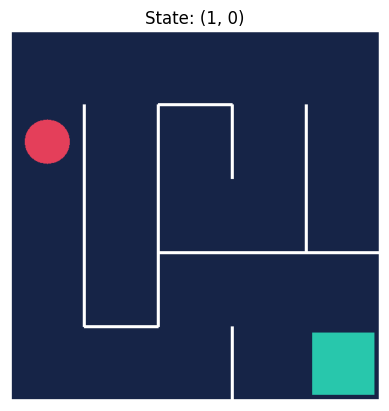

In [3]:
# general overview how to use the Maze class

env = Maze()

# starting the first episode
init_state = env.reset()
print(f"New episode starts in state {init_state}")

# now the agent performs an action
# 0 = up, 1 = right, 2 = down, 3 = left
action = 2
next_state, reward, done, info = env.step(action)
print(f"After moving down 1 row, the agent is in state: {next_state}")
print(f"After moving down 1 row, we got a reward of: {reward}")
print("After moving down 1 row, the task is", "" if done else "not", "finished")

render_image(env.render(mode="rgb_array"), next_state)

# close the environment
env.close()

### States

The maze consists of a 5x5 grid so $S$ contains 25 different states.

$s = (row, column) \quad \text{row, column} \in \{0,1,2,3,4\}$<br>
$S = \{(0,0),(0,1),(0,2),\dots\}$

In [4]:
env = Maze()
print(f"The initial state is: {env.reset()}")
print(f"The space state is of type: {env.observation_space}")

The initial state is: (0, 0)
The space state is of type: MultiDiscrete([5 5])


### Actions

The agent can take four different actions: $a \in \{0,1,2,3\}$

- 0 = move up
- 1 = move right
- 2 = move down
- 3 = move left

In [5]:
print(f"An example of a valid action is: {env.action_space.sample()}")
print(f"The action state is of type: {env.action_space}")

An example of a valid action is: 0
The action state is of type: Discrete(4)


### Trajectory

$\tau = S_0,A_0,R_1,S_1,A_1,R_2,S_2,\dots, R_N, S_N$

In [6]:
state = env.reset()
trajectory = []
trajectory_length = 3

for _ in range(trajectory_length):
    action = env.action_space.sample()
    next_state, reward, done, extra_info = env.step(action)
    trajectory.append([state, action, reward, done, next_state])
    state = next_state
env.close()

print(f"The trajectory of length {trajectory_length} looks like this:\n")
for t in trajectory:
    print(t)

The trajectory of length 3 looks like this:

[(0, 0), 1, -1.0, False, (0, 1)]
[(0, 1), 1, -1.0, False, (0, 2)]
[(0, 2), 0, -1.0, False, (0, 2)]


### Episode

$\tau = S_0,A_0,R_1,S_1,A_1,R_2,S_2,\dots, R_T, S_T$

An episode is a trajectory that goes from the initial state of the process to the final one where $T$ is the terminal state.

In [15]:
state = env.reset()
episode = []
done = False
counter = 0

while not done:
    counter += 1
    action = env.action_space.sample()
    next_state, reward, done, extra_info = env.step(action)
    episode.append([state, action, reward, done, next_state])
    state = next_state
env.close()

print(f"The episode took {counter} steps & looks like this:\n")
for e in episode:
    print(e)

The episode took 170 steps & looks like this:

[(0, 0), 3, -1.0, False, (0, 0)]
[(0, 0), 1, -1.0, False, (0, 1)]
[(0, 1), 0, -1.0, False, (0, 1)]
[(0, 1), 2, -1.0, False, (1, 1)]
[(1, 1), 3, -1.0, False, (1, 1)]
[(1, 1), 3, -1.0, False, (1, 1)]
[(1, 1), 2, -1.0, False, (2, 1)]
[(2, 1), 1, -1.0, False, (2, 1)]
[(2, 1), 2, -1.0, False, (3, 1)]
[(3, 1), 1, -1.0, False, (3, 1)]
[(3, 1), 2, -1.0, False, (3, 1)]
[(3, 1), 1, -1.0, False, (3, 1)]
[(3, 1), 3, -1.0, False, (3, 1)]
[(3, 1), 2, -1.0, False, (3, 1)]
[(3, 1), 3, -1.0, False, (3, 1)]
[(3, 1), 3, -1.0, False, (3, 1)]
[(3, 1), 3, -1.0, False, (3, 1)]
[(3, 1), 3, -1.0, False, (3, 1)]
[(3, 1), 0, -1.0, False, (2, 1)]
[(2, 1), 1, -1.0, False, (2, 1)]
[(2, 1), 0, -1.0, False, (1, 1)]
[(1, 1), 1, -1.0, False, (1, 1)]
[(1, 1), 0, -1.0, False, (0, 1)]
[(0, 1), 2, -1.0, False, (1, 1)]
[(1, 1), 2, -1.0, False, (2, 1)]
[(2, 1), 2, -1.0, False, (3, 1)]
[(3, 1), 3, -1.0, False, (3, 1)]
[(3, 1), 0, -1.0, False, (2, 1)]
[(2, 1), 0, -1.0, False, (1, 

### Reward

$r = (s,a)$

In [8]:
state = env.reset()
action = env.action_space.sample()
_, reward, _, _ = env.step(action)

print(f"We achieved a reward of {reward} by taking action {action} in state {state}")

We achieved a reward of -1.0 by taking action 2 in state (0, 0)


### Return

$G_0 = R_1 + \gamma R_2 + \gamma^2 R_3 + \dots + \gamma^{T-1} R_T$

$G_0$ is the return to the beginnig of the episode.

$\gamma$ will be set to $0.99$.

In [9]:
state = env.reset()
done = False
gamma = 0.99
G_0 = 0
t = 0

while not done:
    action = env.action_space.sample()
    _, reward, done, _ = env.step(action)
    G_0 += gamma ** t * reward
    t += 1
env.close()

print(f"It took {t} moves to find the exit, and each reward r(s,a)=-1, so the return amounts to {G_0}")

It took 732 moves to find the exit, and each reward r(s,a)=-1, so the return amounts to -99.93617917037557


### Policy

$\pi(a|s) \in [0,1]$<br>

Since we have 4 actions that can be taken (up, right, down, left) we start with the following policy: $[0.25, 0.25, 0.25, 0.25]$

In [10]:
def random_policy(state):
    return np.array([0.25] * 4)

In [13]:
def test_agent(environment, policy):
    frames = []
    state = env.reset()
    done = False
    frames.append(env.render(mode="rgb_array"))

    while not done:
        action_probs = policy(state)
        action = np.random.choice(range(4), 1, p=action_probs)
        next_state, reward, done, extra_info = env.step(action)
        img = env.render(mode="rgb_array")
        frames.append(img)
        state = next_state

    return display_video(frames)


video = test_agent(env, random_policy)
video